**process**

① STT - ② Summarization - ③ etc


    STT : pre-processing -> STT -> post-processing

* pre-processing
    * audio fragmentation
    * spleeter
* post-processing
    * NFC (NFD -> NFC, 한글 깨짐 현상 처리)
    * EF (종결어미에 마침표 인위 추가)
    * Spell Check (han-spell)

# stt_inference


In [1]:
%%capture
!pip install --upgrade transformers
!pip install torch
!pip install librosa

import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer, AutoModelForCTC
import librosa


In [2]:
stt_tokenizer = Wav2Vec2Tokenizer.from_pretrained("42MARU/ko-spelling-wav2vec2-conformer-del-1s")
stt_model = AutoModelForCTC.from_pretrained("42MARU/ko-spelling-wav2vec2-conformer-del-1s")


def stt_inference(sound_file_path):
    audio, sampling_rate = librosa.load(sound_file_path, sr=16000)
    input_values = stt_tokenizer(audio, return_tensors = 'pt').input_values
    logits = stt_model(input_values).logits
    predicted_ids = torch.argmax(logits, dim =-1)
    transcriptions = stt_tokenizer.decode(predicted_ids[0])
    return transcriptions

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:752: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


Downloading:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/720M [00:00<?, ?B/s]

# NFC

In [ ]:
import unicodedata
stt_result = unicodedata.normalize('NFC',stt_result)

# EF 
* Ending_Final (종결 어미)
* konlpy Kkma 라이브러리 이용 종결어미 확인


    5가지 모듈 중 Kkma를 사용한 이유
        1. 종결어미 형태소를 가장 세분화하여 분석
        2. 시간은 가장 오래 걸리지만 실시간 STT가 아니고, 정확한 분석이 중요하기 때문

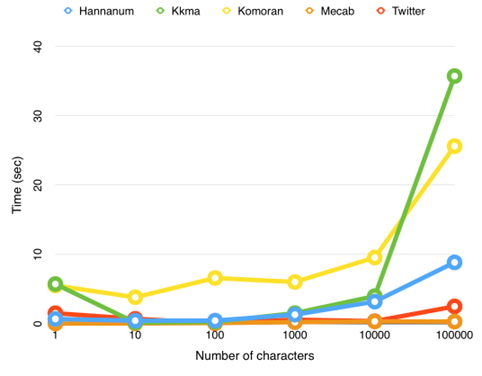

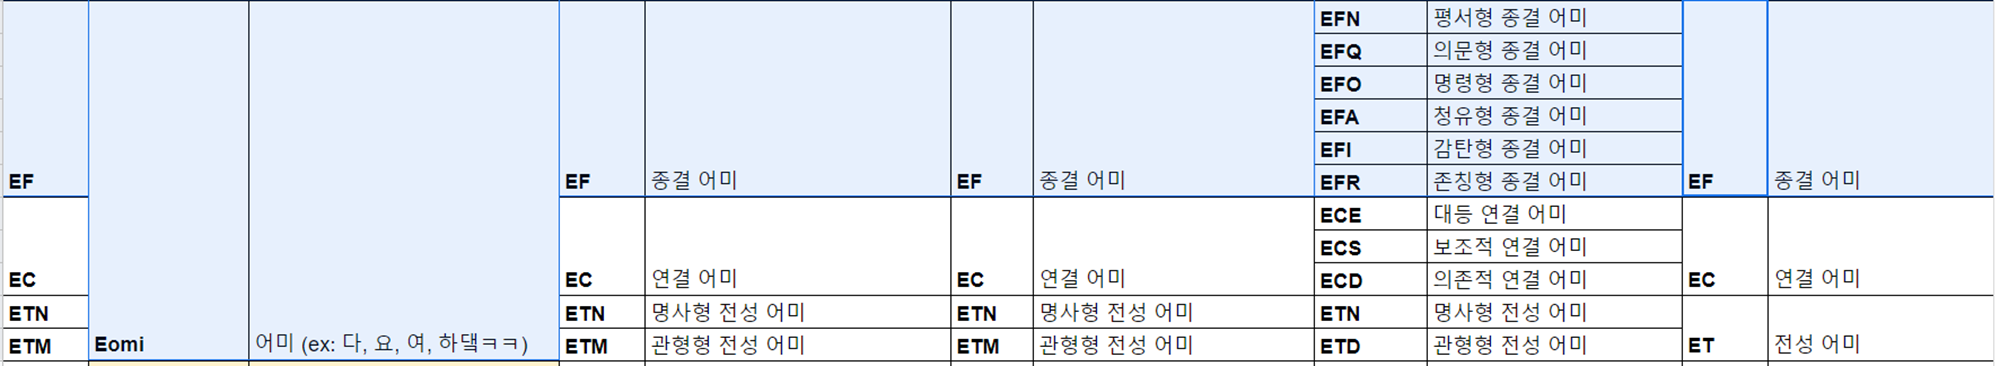

* 통계적 기법으로 많이 나오는 문장에 마침표 강제 추가
    * 비슷한 발음도 함께 추가

In [ ]:
# !pip install konlpy
# from konlpy.tag import Kkma

EF = ['니다', '아요', '어요', '니까', '든요', '에요', '예요', '거야', '데요', '대요', '되요', '돼요', '까요']

for i in range(len(EF)):
    stt_result = stt_result.replace(EF[i], EF[i]+".")

그 외 deepmultilingualpunctuation 모델을 이용하여 마침표를 추가하려고 시도했으나,

성능이 좋지 않고, 모델이 무거워지는 오버헤드가 발생하여 미사용

In [ ]:
%%capture
!pip install deepmultilingualpunctuation

punc_model = PunctuationModel()
punc_text = "My name is Clara and I live in Berkeley California Ist das eine Frage Frau Müller"
punc_result = punc_model.restore_punctuation(punc_text)
print(punc_result)

# han spell
* 네이버 맞춤법 검사기

In [5]:
%%capture
!git clone https://github.com/ssut/py-hanspell.git
%cd py-hanspell
!python setup.py install 

from hanspell import spell_checker

In [6]:
def han_spell(text):
    spelled_sent = spell_checker.check(text)
    checked_sent = spelled_sent.checked
    return checked_sent

네이버 맞춤법 검사기는 한 번에 500글자씩 가능

-> 5문장씩 나누어서 맞춤법 검사 시행

In [ ]:
tmp_stt = stt_result.replace(".", ".^%^%^%^").split("^%^%^%^")
tmp_stt_result = []
tmp = ""

for i in range(len(tmp_stt)):
    tmp += tmp_stt[i]
    if i%5==0:
        tmp_stt_result.append( tmp )
        tmp = ""
if tmp!="":
    tmp_stt_result.append( tmp )
    
stt_result = ""
for i in tmp_stt_result:
    stt_result += han_spell(i)
stt_result += "."
print("sepll chk :", stt_result)

# text_summarize

In [8]:
%%capture
!pip install nltk

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, PreTrainedTokenizerFast, BartForConditionalGeneration
import nltk
nltk.download('punkt')

sum_model_dir = "psyche/KoT5-summarization"
sum_tokenizer = AutoTokenizer.from_pretrained(sum_model_dir)
sum_model = AutoModelForSeq2SeqLM.from_pretrained('hyorea1/KoT5-test-add-data-from5ep')


* t5_summarize : 한 번에 모든 문장 요약
* split_paragraph : 문장 단위로 리스트화
* summary_every_three : 세 문장 단위로 요약

In [9]:
def t5_summarize(text):
    max_input_length = 1026

    inputs = ["summarize: " + text]

    inputs = sum_tokenizer(inputs, max_length=max_input_length, truncation=True, return_tensors="pt")
    output = sum_model.generate(**inputs, num_beams=2, do_sample=True, min_length=200, max_length=1024)
    decoded_output = sum_tokenizer.batch_decode(output, skip_special_tokens=True)[0]
    predicted_title = nltk.sent_tokenize(decoded_output.strip())[0]

    return predicted_title 

#######################################

def split_paragraph(text):
    text = text.replace(".", ".$$##$$#$#$#$#$$").replace("?", ".$$##$$#$#$#$#$$")
    sen_lst = text.split("$$##$$#$#$#$#$$")[:-1]
        
    return sen_lst

#######################################

def summary_every_three(sen_lst):
    count=0
    tmp = ""
    summary_lst = []
    
    for i in range(0, len(sen_lst)):
        if count == 5:
            summary = t5_summarize(tmp)
            summary_lst.append("▪️ " + summary)
            tmp=""
            count=0
        
        tmp += sen_lst[i]
        count += 1
            
    if tmp != "":
        summary_lst.append("▪️ " + t5_summarize(tmp))
    print("sum_lst",summary_lst)
    return summary_lst

In [ ]:
step1 = split_paragraph(stt_result)
step2 = summary_every_three(step1)
sum_result = ""
for i in step2:
    sum_result += i + "\n\n"  # step 3
    
print("step3 : ", sum_result)

# save to docx file (in Flask)

In [ ]:
%%capture
!pip install htmldocx

from datetime import datetime
from docx import Document
from htmldocx import HtmlToDocx

In [ ]:
def html_to_docx(content_list):
    document = Document()
    new_parser = HtmlToDocx()
    
    html = "<h1>제목 : {0}</h1>".format( content_list[1] )
    new_parser.add_html_to_document(html, document)
    html = "<h1>키워드 : {0}</h1>".format( content_list[5] )
    new_parser.add_html_to_document(html, document)
    html = "<h1>내용 : </h1>"
    new_parser.add_html_to_document(html, document)
    
    spl = content_list[6].split("\n")
    for i in spl:
        html = "<h1>{0}</h1>".format( i )
        new_parser.add_html_to_document(html, document)

    now = datetime.now()
    str_now = str(now)[:-10].replace(":", "")
    docx_filename = 'C:\\temp\\{}.docx'.format(str_now)

    document.save(docx_filename)

# pipe-line

In [17]:
%cd ..

/content


In [ ]:
STT_result = stt_inference('sch_hit_90.wav')
print("STT :", STT_result)
print()    


NFC_result = unicodedata.normalize('NFC', STT_result)
print("NFC :", NFC_result)
print()    


EF = ['니다', '아요', '어요', '니까', '든요', '에요', '예요', '거야', '데요', '대요', '되요', '돼요', '까요']
for i in range(len(EF)):
    EF_result = NFC_result.replace(EF[i], EF[i]+".")

print("add EF :", EF_result)


tmp_stt = EF_result.replace(".", ".^%^%^%^").split("^%^%^%^")
tmp_stt_result = []
tmp = ""
for i in range(len(tmp_stt)):
    tmp += tmp_stt[i]
    if i%5==0:
        tmp_stt_result.append( tmp )
        tmp = ""
if tmp!="":
    tmp_stt_result.append( tmp )
splchk_result = ""
for i in tmp_stt_result:
    splchk_result += han_spell(i)
splchk_result += "."
print("spell chk :", splchk_result)


In [ ]:
step1 = split_paragraph(splchk_result)
print("step1 : ",step1)
print()
print()

step2 = summary_every_three(step1)
print("step2 : ",step2)
print()
print()

sum_result = ""
for i in step2:
    sum_result += i + "\n\n"
    
print("step3 : ", sum_result)
